Competition Description
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies.

Well, Thanks to Holf Yuen for creating this amazing notebook.

Before going ahead to we should follow through the very basic things which are actively related with any machine learning problem along with this one too. F1 is calculated as follows

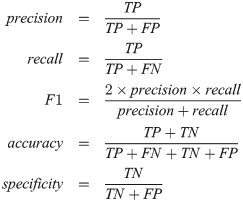

True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!

False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.

False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

Contents: in this notebook which will be coverd .

# Basic NLP on Disaster Tweets

This is a getting started competition of predicting whether a tweet is actually referring to real disasters.

Contents:
1. Basic exploration
2. Keywords
3. Locations
4. Spoiler Alert!
5. Clean up text
6. Text statistics
7. Unigrams and bigrams
8. Encoding and Vectorizers
9. Simple model

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

plt.rcParams.update({'font.size': 14})

# Load data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sub_sample = pd.read_csv("data/sample_submission.csv")

print (train.shape, test.shape, sub_sample.shape)

(7613, 5) (3263, 4) (3263, 2)


## 1. Basic Exploration

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.duplicated().sum()

0

There are 52 duplicated rows. The duplicates will be removed.

In [5]:
train = train.drop_duplicates().reset_index(drop=True)

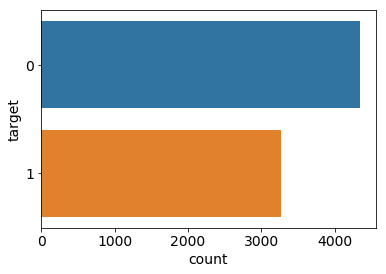

In [11]:
# Class balance
# train.target.value_counts()
sns.countplot(y=train.target);

In [12]:
# NA data
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Text is all non-null. Only a small percentage of tweets have no keyword. Location has much more null values.

## 2. Keywords

In [14]:
# Check number of unique keywords, and whether they are the same for train and test sets
print (train.keyword.nunique(), test.keyword.nunique())
print (set(train.keyword.unique()) - set(test.keyword.unique()))

221 221
set()


Train and test have the same set of keywords

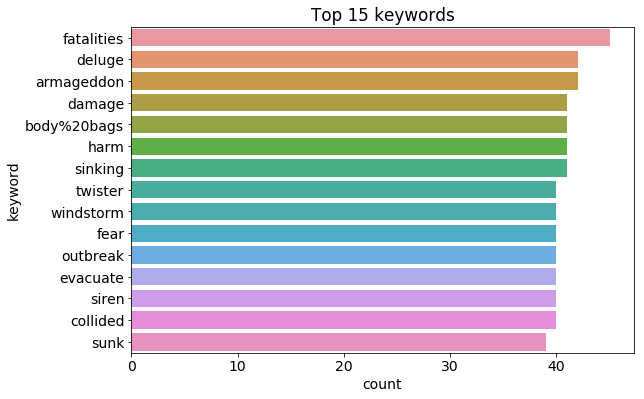

In [15]:
# Most common keywords
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()
# train.keyword.value_counts().head(10)

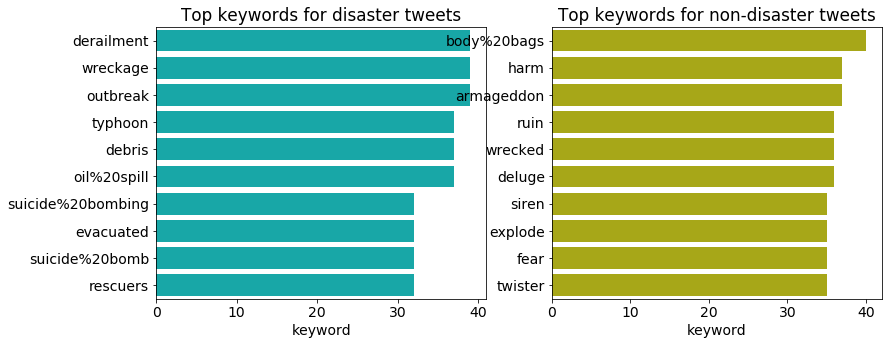

In [16]:
kw_d = train[train.target==1].keyword.value_counts().head(10)
kw_nd = train[train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

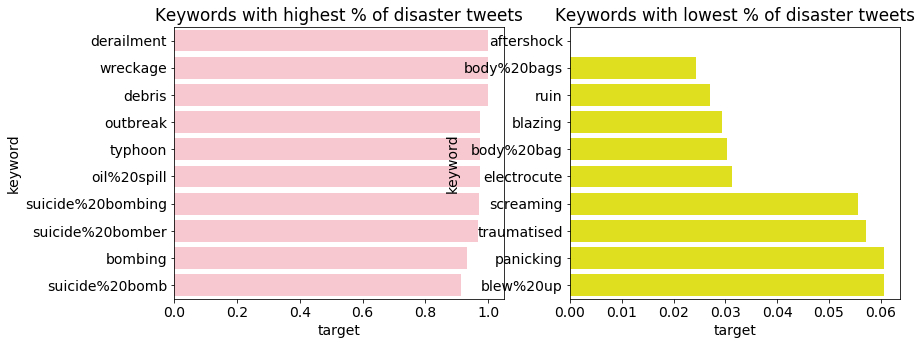

In [17]:
top_d = train.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = train.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

## 3. Locations

In [18]:
# Check number of unique keywords and locations
print (train.location.nunique(), test.location.nunique())

3341 1602


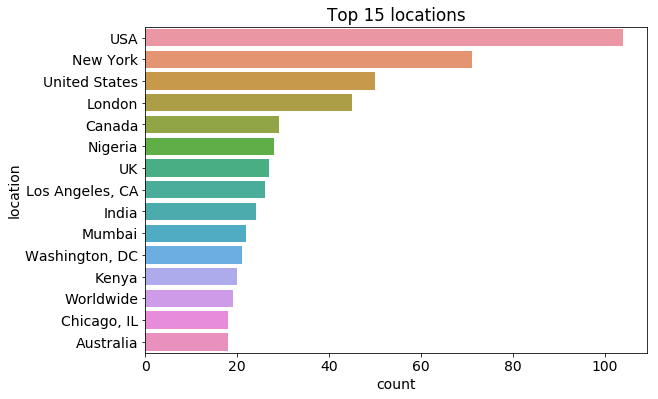

In [19]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of disaster tweets for common locations.

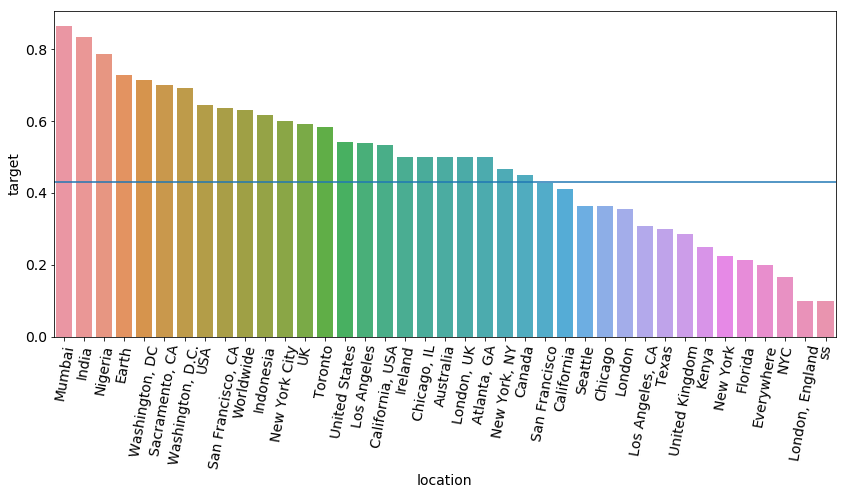

In [20]:
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

The top 3 locations with highest % of disaster tweets are **Mumbai, Inida, and Nigeria**. As the location data is not clean, we see some interesting cases, such as **'London, UK' saw a higher-than-average % of disaster tweets, but 'London' is below average**. We try to clean up the location and see if there is any difference:

In [21]:
# Fill NA values
for col in ['keyword','location']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train['location_clean'] = train['location'].apply(lambda x: clean_loc(str(x)))
test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x)))

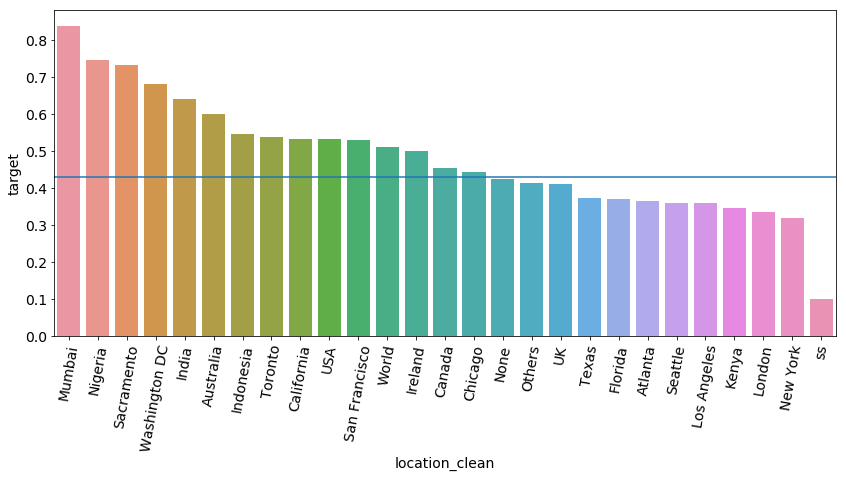

In [22]:
top_l2 = train.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

Mumbai and Nigeria are still on the top. Other than the strange 'ss', London and New York made the bottom of % of disaster tweets.

## 4. Spoiler Alert: You Can Get Perfect Score in (public) Leader Board

You will see in the public leaderboard, many participants got a perfect score. It is because the whole dataset with label is available online (one copy available [on Kaggle](https://www.kaggle.com/jannesklaas/disasters-on-social-media)). You can find the correct label of our test set so you can achieve perfect score.

In such case, the ranking on public leaderboard is meaningless. The good news is, you can now focus on learning NLP and modelling skills with this dataset, instead of fighting for higher position on the leaderboard!

(Reference: [szelee's notebook](https://www.kaggle.com/szelee/a-real-disaster-leaked-label/notebook))

In [24]:
leak = pd.read_csv("data/socialmedia-disaster-tweets-DFE.csv", encoding='latin_1')
leak['target'] = (leak['choose_one']=='Relevant').astype(int)
leak['id'] = leak.index
leak = leak[['id', 'target','text']]
merged_df = pd.merge(test, leak, on='id')
sub1 = merged_df[['id', 'target']]
sub1.to_csv('submit_1.csv', index=False)

## 5. Clean up Text Column

Here we clean up the text column by:
- Making a 'clean' text column, removing links and unnecessary white spaces
- Creating separate columns containing lists of hashtags, mentions, and links

In [25]:
import re

test_str = train.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [26]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train = process_text(train)
test = process_text(test)

## 6. Create statistics from texts

In [29]:
from wordcloud import STOPWORDS

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train = create_stat(train)
test = create_stat(test)

print(train.shape, test.shape)

(7613, 19) (3263, 18)


In [30]:
train.corr()['target'].drop('target').sort_values()

stop_word_count     -0.111250
mention_count       -0.049654
caps_ratio          -0.014970
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.096435
Name: target, dtype: float64

All of the statistics have very low correlation with the target variable

## 7. Most frequent words and bigrams

What are the most common unigrams (single word) and bigrams (two-word sequence)?

In [34]:
from nltk import FreqDist, word_tokenize

# Make a set of stop words
stopwords = set(STOPWORDS)
# more_stopwords = {'https', 'amp'}
# stopwords = stopwords.union(more_stopwords)

In [36]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tsudh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

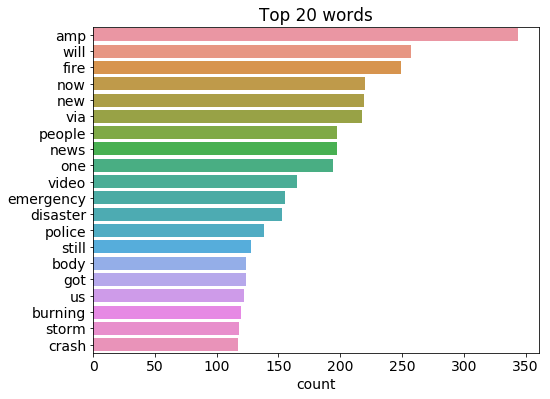

In [38]:
# Unigrams

word_freq = FreqDist(w for w in word_tokenize(' '.join(train['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

We try to distinguish disaster and non-disaster tweets:

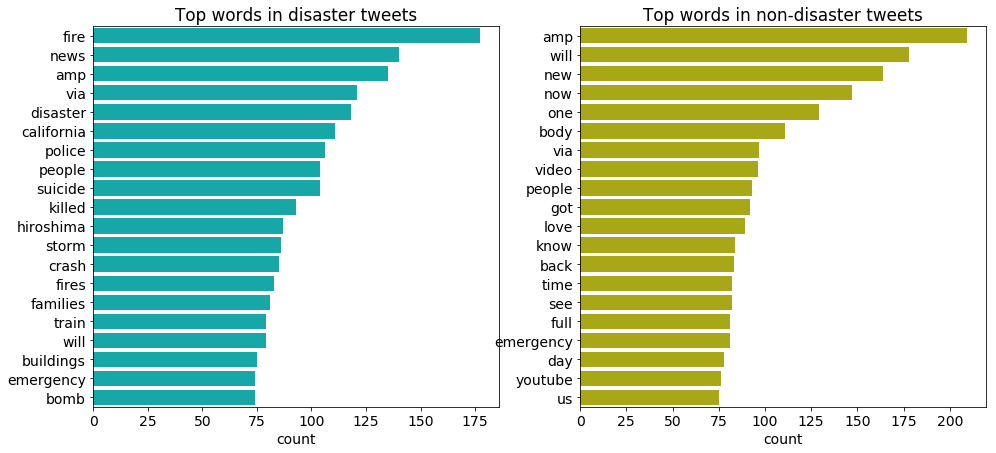

In [39]:
plt.figure(figsize=(16,7))
plt.subplot(121)
freq_d = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_d = pd.DataFrame.from_dict(freq_d, orient='index', columns=['count'])
top20_d = df_d.sort_values('count',ascending=False).head(20)
sns.barplot(top20_d['count'], top20_d.index, color='c')
plt.title('Top words in disaster tweets')
plt.subplot(122)
freq_nd = FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_nd = pd.DataFrame.from_dict(freq_nd, orient='index', columns=['count'])
top20_nd = df_nd.sort_values('count',ascending=False).head(20)
sns.barplot(top20_nd['count'], top20_nd.index, color='y')
plt.title('Top words in non-disaster tweets')
plt.show()

Findings:
- Top two words in disaster tweets: 'fire' and 'news', don't make the top 20 on unreal disaster tweets.
- Words are more specific for real disaster tweets (e.g. 'califonia', 'hiroshima', 'fire', 'police', 'suicide', 'bomb').

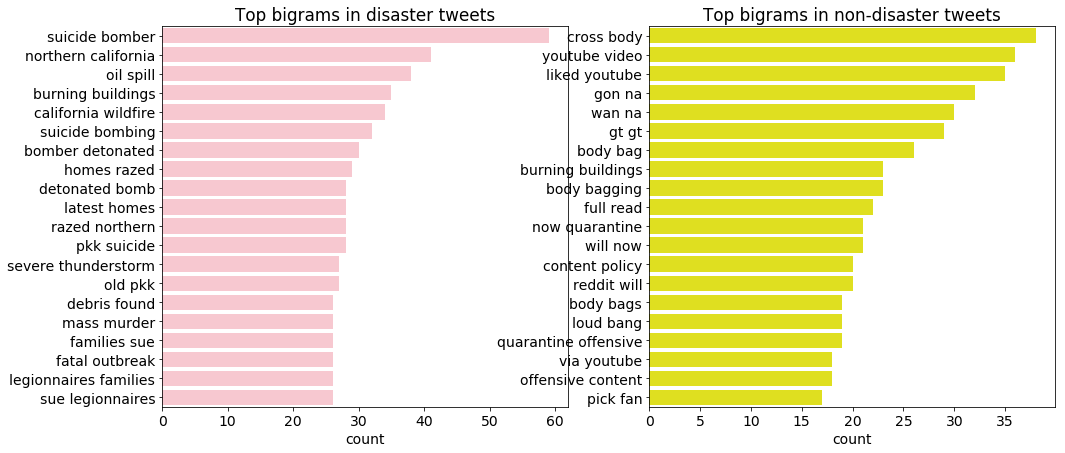

In [40]:
# Bigrams

from nltk import bigrams

plt.figure(figsize=(16,7))
plt.subplot(121)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='pink')
plt.title('Top bigrams in disaster tweets')
plt.subplot(122)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20], color='yellow')
plt.title('Top bigrams in non-disaster tweets')
plt.show()

Findings:
- Most top bigrams in disaster tweets show certain kinds of catestrophe (e.g. suicide bomber, oil spill, california wildfire); for non-disaster tweets, only 'burning buildings' as top bigram look like a disaster;
- Top bigrams in disaster tweets have a more casual tone;
- 'youtube' appears in three of the twenty bigrams for non-disaster tweets; none in disaster tweets

## 8. Encoding and Vectorizers

As part of feature generation, we will:
- Apply target encoding to keyword and location (cleaned)
- Count Vectorize cleaned text, links, hashtags and mentions columns

In [41]:
import category_encoders as ce

features = ['keyword', 'location_clean']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train[features],train['target'])

train = train.join(encoder.transform(train[features]).add_suffix('_target'))
test = test.join(encoder.transform(test[features]).add_suffix('_target'))

ModuleNotFoundError: No module named 'category_encoders'

Vectorization: TBC

## 9. Base Model: Logistic Regression

We try the simplest model with logistic regression, based on keyword, location and statistics we created.

As the competition uses F-1 score, our cv also use this scoring.

Reference: [scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']

X_train = train.drop(columns = features_to_drop + ['target'])
X_test = test.drop(columns = features_to_drop)
y_train = train.target

lr = LogisticRegression(solver = 'liblinear')
lr.fit(X_train, y_train)
cv5 = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1')
print(cv5)
print(np.mean(cv5))

[0.50221828 0.51277683 0.48658009 0.46012832 0.51183971]
0.49470864554850136


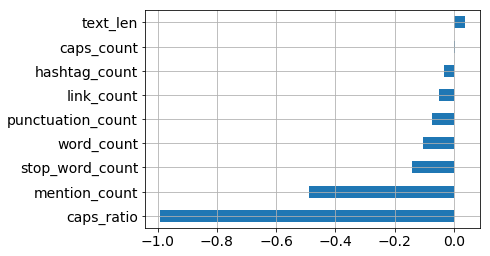

In [43]:
pd.Series(np.transpose(lr.coef_[0]), index=X_train.columns).sort_values().plot.barh(grid=True)

In [44]:
y_test = lr.predict(X_test)

submit = sub_sample.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

That's it for now. Stay tuned for more analysis!

In [1]:
print ('Training accuracy: %.4f' % pipeline.score(X_train, y_train))

NameError: name 'pipeline' is not defined